# Phenotypic classification based on gene expression
Below are classification models for assignment of multiple phenotypes to expression samples (multi-label classification).

In [70]:
import os
import sys
from importlib import reload

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)


import pandas as pd
import numpy as np
from sklearn.metrics import precision_recall_fscore_support,roc_auc_score
from skmultilearn.model_selection import IterativeStratification
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
import sklearn.preprocessing as pp
import altair as alt
#alt.renderers.enable('notebook')
from IPython.display import display
import scipy.stats as ss
import matplotlib.pyplot as plt 
from sklearn.metrics import make_scorer
import seaborn as sb
from sklearn.utils.class_weight import compute_class_weight

from networks.functionsDENet import loadPickle,savePickle
from stages_DE.stages_library import PHENOTYPES

In [2]:
proteus=True
if proteus:
    pathClassification = '/home/khrovatin/timeTrajectoriesNet/data/stages/classification/'
else:
    pathClassification = '/home/karin/Documents/timeTrajectories/data/stages/classification/'

## Training models

Data was previoulsy split into training and test set (10%). For cross validation used above only the training set is used. The split was done so that it preserves proportions of individual labels in training and test set. 

Phenotype tag_spore was not modeled as it has only 3 samples. Nevertheless, its data is still used in modeling other target features (all labels are 0).

In [3]:
X_train, Y_train, X_test, Y_test = loadPickle(pathClassification + 'train_test.pkl')
order=loadPickle(pathClassification+'target_order.pkl')

In [87]:
class_weight=[]
labels=[0,1]
for class_idx in range(Y_train.shape[1]):
    label_weights=compute_class_weight('balanced',labels,Y_train[:,class_idx])
    class_weight.append(dict(zip(labels,label_weights)))

Classification is based on logistic regression. To create multi-label models problem transformation techniques are used: classificator chains and binary relevance. Classificator chain produces a model for each target in order, by using original features and the labels of previously modeled target features as features. Binary relevance constructs a model for each target separately and then predicts the final label set as a union of predictuions from target feature specific models. 

Features are selected with l1 regularisation. Five fold cross validation is used to compare results of different regularisation parameters (C), using the training set. 

In [4]:
split = IterativeStratification(n_splits=5, order=1)

clf = RandomForestClassifier(criterion='entropy',n_jobs=10,class_weight=class_weight)
#Params dist
param_dist={
'n_estimators':[20,50,100,150,200,500,1000],
'max_depth':[20,50,100,200,300,400,500,700,1000,1500],
'min_samples_leaf':[2,3,4,5],
'max_samples':ss.uniform(0.1,0.9),
}
 
def F_score_macro(y_true, y_pred): return precision_recall_fscore_support(y_true, y_pred, average='macro') [2]
def precision_macro(y_true, y_pred): return precision_recall_fscore_support(y_true, y_pred, average='macro') [0]
def recall_macro(y_true, y_pred): return precision_recall_fscore_support(y_true, y_pred, average='macro') [1]

scoring = {'accuracy': 'accuracy', 'F_score_macro': make_scorer(F_score_macro),
           'precision_macro': make_scorer(precision_macro), 'recall_macro': make_scorer(recall_macro)}

random_search = RandomizedSearchCV(estimator=clf, param_distributions=param_dist,
                                   n_iter=300, scoring=scoring,n_jobs=20,cv=split,refit=False)
random_search.fit(X_train, Y_train)
#savePickle(pathClassification+'randomForestGridSearch.pkl',random_search.cv_results_)

RandomizedSearchCV(cv=IterativeStratification(n_splits=5, order=1, random_state=None,
            sample_distribution_per_fold=None),
                   error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight='balanced_subsample',
                                                    criterion='entropy',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    mi...
                                        'max_samples': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7f

In [123]:
random_search=loadPickle(pathClassification+'randomForestGridSearch.pkl')
df_results = { key:value for key,value in random_search.items() if key !='params'}
df_results=pd.DataFrame(df_results)

In [124]:
param_cols=[]
for param in param_dist.keys():
    param_cols.append('param_'+param)
params_data=pd.DataFrame(pp.minmax_scale(df_results[param_cols]),columns=param_cols)

score_cols=[]
score_std_cols=[]
for score in scoring.keys():
    score_cols.append('mean_test_'+score)
    score_std_cols.append('std_test_'+score)
    
heatmap_data= pd.concat([params_data, df_results[score_cols]], axis=1).sort_values('mean_test_F_score_macro',ascending=False)

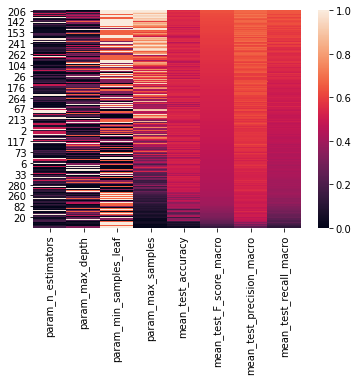

In [125]:
sb.heatmap(heatmap_data)

In [126]:
df_results=df_results.sort_values('mean_test_F_score_macro',ascending=False)
df_results.head(10)[score_cols+score_std_cols+param_cols]

,mean_test_accuracy,mean_test_F_score_macro,mean_test_precision_macro,mean_test_recall_macro,std_test_accuracy,std_test_F_score_macro,std_test_precision_macro,std_test_recall_macro,param_n_estimators,param_max_depth,param_min_samples_leaf,param_max_samples
206,0.544098,0.639017,0.702000,0.643410,0.067816,0.035879,0.046680,0.053396,200,700,5,0.925333
183,0.543358,0.634463,0.677449,0.647929,0.052150,0.022907,0.063529,0.044271,200,20,5,0.998991
171,0.566948,0.633622,0.680915,0.649017,0.063137,0.039209,0.054850,0.056429,100,100,5,0.992241
89,0.544179,0.633473,0.682380,0.644535,0.055517,0.043821,0.068697,0.065431,150,700,5,0.973344
84,0.531907,0.629354,0.663142,0.649340,0.040048,0.061458,0.082113,0.063050,100,500,5,0.994346
13,0.541197,0.627928,0.662056,0.644566,0.068116,0.032991,0.057363,0.034061,500,200,5,0.885847
60,0.556684,0.624981,0.705385,0.610541,0.057608,0.044453,0.071425,0.053453,150,500,4,0.982097
15,0.548094,0.622933,0.674069,0.637107,0.047774,0.030741,0.056127,0.044334,500,700,5,0.941092
132,0.538023,0.620852,0.678419,0.623696,0.062977,0.028919,0.056740,0.036575,1000,1500,5,0.885965
141,0.523357,0.620212,0.668979,0.643553,0.068098,0.030816,0.053890,0.028373,50,400,5,0.952089


The below does not account for confounding effect of other parameters, but it shows that it performs well at a wide range of parameter values.

In [159]:
groupped=df_results.groupby('param_max_depth')['mean_test_F_score_macro']
for param_max_depth in df_results['param_max_depth'].sort_values().unique():
    data=groupped.get_group(param_max_depth)
    print('%-12s%-6.3f%-3s%-3.3f' % ('max_depth = '+str(param_max_depth)+': F_score ', data.mean(),'+-',data.sem()))

max_depth = 20: F_score 0.466 +- 0.020
max_depth = 50: F_score 0.495 +- 0.012
max_depth = 100: F_score 0.481 +- 0.023
max_depth = 200: F_score 0.517 +- 0.012
max_depth = 300: F_score 0.498 +- 0.014
max_depth = 400: F_score 0.486 +- 0.020
max_depth = 500: F_score 0.507 +- 0.017
max_depth = 700: F_score 0.515 +- 0.016
max_depth = 1000: F_score 0.493 +- 0.012
max_depth = 1500: F_score 0.489 +- 0.015


Choosen parameters: n_estimatros tested in approx range [40,600], max_depth=200 (as it performs well at different depths, so a lower depth can be probably chosen), min_samples_leaf=5, max_samples=1.

In [163]:
clf = RandomForestClassifier(criterion='entropy', class_weight=class_weight,
                             max_depth=200,min_samples_leaf=5,max_samples=None, #max_samples None is 100% of samples
                             warm_start=True,oob_score=True)

error_rate=[]
features=[]
n_estimators_range=range(40, 601,5)
for n_estimators in n_estimators_range:
    #print(n_estimators)
    clf.set_params(n_estimators=n_estimators)
    clf.fit(X_train, Y_train)
    oob_error = 1 - clf.oob_score_
    error_rate.append(oob_error)
    nonzero_feats=(clf.feature_importances_>0).sum()
    features.append(nonzero_feats)

Text(0, 0.5, 'N non null features')

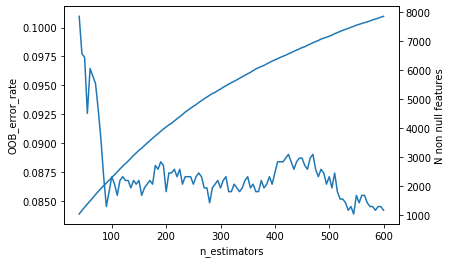

In [164]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(n_estimators_range,error_rate,label='OOB_error_rate')
ax1.set_ylabel('OOB_error_rate')
ax1.set_xlabel('n_estimators')
ax2.plot(n_estimators_range,features,label='N non null features')
ax2.set_ylabel('N non null features')

Selected value for n_estimators = 100.

### Tree for comparison with other classifiers.

In [167]:
prfs_all=pd.DataFrame()
rac_all=pd.DataFrame()
feats_all=pd.DataFrame()
split = IterativeStratification(n_splits=5, order=1)
fold=0
for train_index, test_index in split.split(X_train, Y_train):
    fold += 1
    print(fold)
    X_train_fold, X_test_fold = X_train[train_index], X_train[test_index]
    Y_train_fold, Y_test_fold = Y_train[train_index], Y_train[test_index]
    classifier =RandomForestClassifier(criterion='entropy', class_weight=class_weight,
                             max_depth=200,min_samples_leaf=5,max_samples=None,n_estimators=100
                            ).fit(X_train_fold,Y_train_fold)

    Y_predict_fold = classifier.predict(X_test_fold)
    Y_p_fold = classifier.predict_proba(X_test_fold)
    Y_p_fold_parsed=[]
    for class_idx in range(len(Y_p_fold)):
        label_idx=np.where(classifier.classes_[0] ==1)[0][0]
        Y_p_fold_parsed.append(Y_p_fold[class_idx][:,label_idx])
    Y_p_fold =np.array(Y_p_fold_parsed).T  
    
    prfs=pd.DataFrame(precision_recall_fscore_support(Y_test_fold, Y_predict_fold),index=['precision','recall','F_score','support']).T
    prfs['Stage']=order
    prfs_all=prfs_all.append(prfs)
    prfs=list(precision_recall_fscore_support(Y_test_fold, Y_predict_fold, average='micro'))
    prfs.append('all')
    prfs=dict(zip(['precision','recall','F_score','support','Stage'],prfs))
    prfs_all = prfs_all.append( prfs,ignore_index=True)
    rac=dict(zip(['roc_auc'],[ roc_auc_score(Y_test_fold, Y_p_fold, average='micro')]))
    rac_all=rac_all.append(rac,ignore_index=True)
    feats_all = feats_all.append({'Stage':'all','N_features':(classifier.feature_importances_>0).sum()},ignore_index=True)
savePickle(pathClassification+'randomForest.pkl',{'prfs':prfs_all,'rac':rac_all,'featsN':feats_all})

1
2
3
4
5


## Results
Five fold cross validation statistics for different models and regularization strengths (C). Stage: results for individual targets (phenotypes) or combined across all target features ('all'). 

The models are not able to reliably predict phenotypes. Besides the below metrics the problems of training the models were also indicated by the models not converging, even when raising max iter for 10x or 40x times compared to the default. 

In [66]:
# Plot scatter plot with multiple jittered categories
# From https://datavizpyr.com/stripplot-with-altair-in-python/
def scatter_catgory(df,categories, Y, colour=None,shape=None,title=''):
    params_dict={}
    if colour is not None:
        params_dict['color']=alt.Color(colour)
    if shape is not None:
        params_dict['shape']=alt.Shape(shape)
    return alt.Chart(df, width=120,title=title).mark_point(size=20).encode(
        x=alt.X('jitter:Q',title=None,axis=alt.Axis(values=[0], ticks=True, grid=False, labels=False),
            scale=alt.Scale(),),
        y=alt.Y(Y,axis=alt.Axis( grid=False)),
        column=alt.Column(categories, header=alt.Header(
            labelAngle=0,titleOrient='bottom',labelOrient='bottom',labelAlign='center',labelPadding=10)),
        **params_dict
    ).transform_calculate(jitter='sqrt(-2*log(random()))*cos(2*PI*random())'
    ).configure_facet(spacing=0
    ).configure_view( stroke=None)

In [153]:
# Mean and SE of scores from cross validation
def summary(df,statistic, split):
    print(statistic,'mean and standard error for each group')
    groups=df[[statistic,split]].groupby(split)
    for group_name in groups.groups.keys():
        data=groups.get_group(group_name)
        print('%-12s%-6.3f%-3s%-3.3f' % (group_name, data.mean()[0],'+-',data.sem()[0]))

### Classifier Binary Relevance with logistic regression

In [155]:
data_binary=loadPickle(pathClassification+'logisticRegressionBinaryRelevance.pkl')
display(scatter_catgory(data_binary['prfs'],'C', 'F_score', 'Stage','Stage'))
display(scatter_catgory(data_binary['prfs'],'C', 'precision', 'Stage','Stage'))
display(scatter_catgory(data_binary['prfs'],'C', 'recall', 'Stage','Stage'))
display(scatter_catgory(data_binary['featsN'],'C', 'N_features','Stage','Stage'))
#display(scatter_catgory(data_binary['rac'],'C', 'roc_auc',title='Micro ROC AUC (across all categories)'))
summary(data_binary['prfs'].query('C ==2'),'F_score',"Stage")

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

F_score mean and standard error for each group
FB          0.684 +- 0.089
all         0.741 +- 0.018
cul         0.791 +- 0.055
disappear   0.370 +- 0.112
lag         0.739 +- 0.040
mhat        0.831 +- 0.092
no_agg      0.873 +- 0.025
slug        0.720 +- 0.031
stream      0.515 +- 0.055
tag         0.779 +- 0.023
tip         0.474 +- 0.086


### Classifier Chain with logistic regression

In [156]:
data_chain=loadPickle(pathClassification+'logisticRegressionChain.pkl')
display(scatter_catgory(data_chain['prfs'],'C', 'F_score', 'Stage'))
display(scatter_catgory(data_chain['prfs'],'C', 'precision', 'Stage'))
display(scatter_catgory(data_chain['prfs'],'C', 'recall', 'Stage'))
display(scatter_catgory(data_chain['featsN'],'C', 'N_features','Stage'))
#display(scatter_catgory(data_chain['rac'],'C', 'roc_auc',title='Micro ROC AUC (across all categories)'))
summary(data_chain['prfs'].query('C ==2'),'F_score',"Stage")

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

alt.Chart(...)

F_score mean and standard error for each group
FB          0.683 +- 0.072
all         0.730 +- 0.013
cul         0.762 +- 0.079
disappear   0.230 +- 0.102
lag         0.717 +- 0.026
mhat        0.880 +- 0.049
no_agg      0.850 +- 0.023
slug        0.724 +- 0.028
stream      0.585 +- 0.065
tag         0.755 +- 0.040
tip         0.443 +- 0.131
